# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Download Prerequisite Data ##
In order for the code cells to run correctly three pickle files need to be downloaded.

In [1]:
# The pickle files are read in by the notebook but
# aren't expected to be sent in back to udacity for evaluation.
# Thus we get the files and provide them in the appropriate paths
# for consumption by the subsequent code cells. Once done we delete
# them from our repo and then submit for evaluation
# wget https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
# unzip traffic-signs-data.zip
# eventually we will also delete the three pickled files extracted by the unzip operation
# rm traffic-signs-data.zip

### Setup relevant module imports ###
For some reason, on the standard udacity-carnd ami, cv2 and tensorflow installs end up on a different path than what the sys.path property is expecting. Hence i had to augment that property.

In [2]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle
import random
import sklearn
import sys
sys.path.append('/usr/local/lib/python3.5/dist-packages')
import cv2
import tensorflow as tf
import time

from PIL import Image
from sklearn.preprocessing import LabelBinarizer
from sklearn.cross_validation import train_test_split
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.layers import flatten

%matplotlib inline



## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [3]:
# Load pickled data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

original_y_train = y_train
setOfLabels = set(y_train)
X_train_mean = np.mean(X_train)

# Free up memory
del train  
del test

In [4]:
# Turn labels into numbers and apply One-Hot Encoding
encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

print('Labels One-Hot Encoded')

Labels One-Hot Encoded


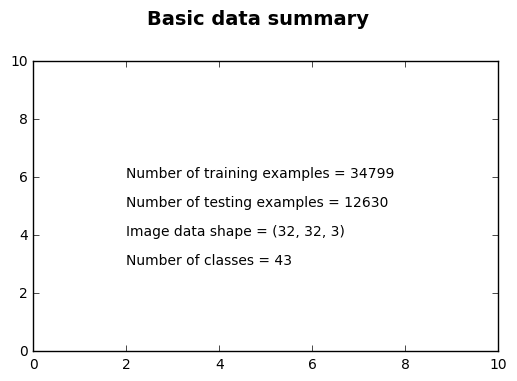

In [5]:
### To start off let's do a basic data summary.
n_train = len(X_train)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(y_train[0])

### plot the basic data summary.
fig = plt.figure()
fig.suptitle('Basic data summary', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.text(2, 6, "Number of training examples = "+str(n_train))
ax.text(2, 5, "Number of testing examples = "+str(n_test))
ax.text(2, 4, "Image data shape = "+str(image_shape))
ax.text(2, 3, "Number of classes = "+str(n_classes))
ax.axis([0, 10, 0, 10])
plt.savefig('output_for_readme/data_summary.jpg')
plt.show()

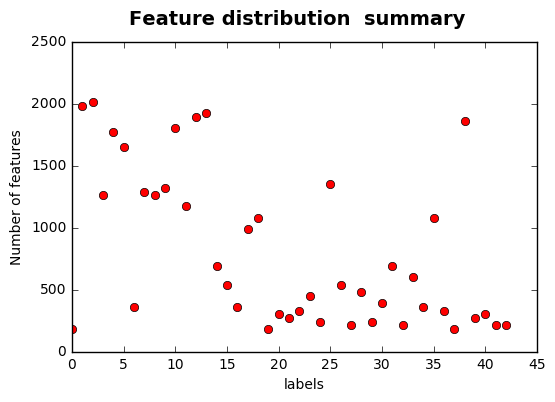

In [6]:
### Data exploration visualization goes here.
# Plot the number of features corresponding to a given label
labelDistribution = {}
for label in setOfLabels:
    for idx, val in enumerate(X_train):
        if original_y_train[idx] == label:
            if label in labelDistribution:
                labelDistribution[label] += 1
            else:
                labelDistribution[label] = 1

labelArray = []
featureCountByLabelArray = []
for key, value in labelDistribution.items():
    labelArray.append(key)
    featureCountByLabelArray.append(value)

plt.plot(labelArray,featureCountByLabelArray,'ro')
plt.suptitle('Feature distribution  summary', fontsize=14, fontweight='bold')
plt.ylabel('Number of features')
plt.xlabel('labels')
plt.savefig('output_for_readme/label_distribution.jpg')
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**
The data will be run through -
- np.mean(axis=3) - this squelches the data to 32X32 from 32x32x3
- normalize_greyscale() - this transforms the 0-255 to 0.1-0.9

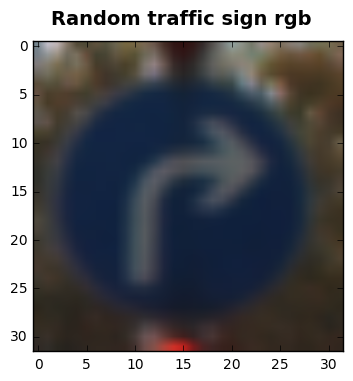

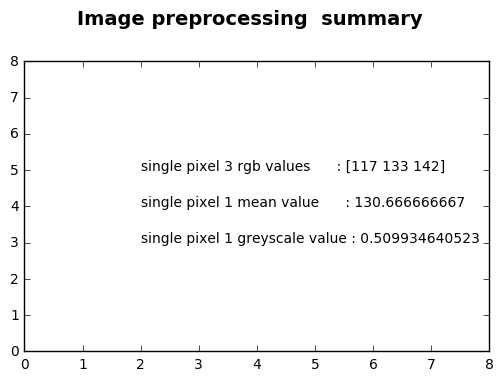

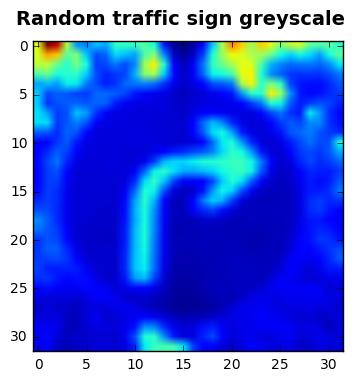

In [7]:
# get a reference to the index of a random traffic sign
randomIdx = random.randint(0,len(X_train))
randomImg = X_train[randomIdx]

# show the random traffic sign before preprocessing 
fig = plt.figure()
fig.suptitle('Random traffic sign rgb', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
plt.savefig('output_for_readme/preprocess_before.jpg')
ax.imshow(randomImg)
# plt.show()

### Preprocess the data here.
### Feel free to use as many code cells as needed.
def normalize_greyscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    x_max = 255
    x_min = 0
    return  a+(((image_data - x_min)*(b - a))/(x_max - x_min)) 

# Preprocess training features
onePixBeforePreProcessing = X_train[randomIdx][0][0]
X_train = np.mean(X_train, axis=3)
onePixAfterSquelching = X_train[randomIdx][0][0]
X_train = normalize_greyscale(X_train)
onePixAfterGreyScaling = X_train[randomIdx][0][0]

### plot sample preprocessed values.
fig = plt.figure()
fig.suptitle('Image preprocessing  summary', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.text(2, 5, 'single pixel 3 rgb values      : '+str(onePixBeforePreProcessing))
ax.text(2, 4, 'single pixel 1 mean value      : '+str(onePixAfterSquelching))
ax.text(2, 3, 'single pixel 1 greyscale value : '+str(onePixAfterGreyScaling))
ax.axis([0, 8, 0, 8])
plt.savefig('output_for_readme/preprocess_summary.jpg')
plt.show()

# show the same random traffic sign after preprocessing 
fig = plt.figure()
fig.suptitle('Random traffic sign greyscale', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
plt.savefig('output_for_readme/preprocess_after.jpg')
ax.imshow(X_train[randomIdx])
# plt.show()

# Apply similar Preprocessing to test features
X_test = np.mean(X_test, axis=3)
X_test = normalize_greyscale(X_test)

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**
we use train_test_split to use 10% of original training features to be validation set. Thus actual training occurs on 90% of the original features.

In [8]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
# Get randomized datasets for training and validation
X_train_features, X_valid_features, y_train_labels, y_valid_labels = train_test_split(
    X_train,
    y_train,
    test_size=0.10,
    random_state=0)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
we use a variant of the leNet architecture
- INPUT -> CONV -> ACT -> POOL -> CONV -> ACT -> POOL -> FLATTEN -> FC -> ACT -> FC

In [9]:
### Train your model here.
### Feel free to use as many code cells as needed.

learning_rate = 0.001
EPOCHS = 30
BATCH_SIZE = 64
dropout = 0.75 # Dropout, probability to keep units

def LeNet(x):
    # Reshape from 2D to 4D. This prepares the data for
    # convolutional and pooling layers.
    x = tf.reshape(x, (-1, 32, 32, 1))
    # Squish values from 0-255 to 0-1.
    x /= 255.

    # TODO: Define the LeNet architecture.
    # Return the result of the last fully connected layer.
    # 28x28x6
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6)))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.dropout(conv1, dropout)

    # 14x14x6
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # 10x10x16
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16)))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)

    # 5x5x16
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten
    fc1 = flatten(conv2)
    
    # (5 * 5 * 16, 120)
    fc1_shape = (fc1.get_shape().as_list()[-1], 120)
    fc1_W = tf.Variable(tf.truncated_normal(shape=(fc1_shape)))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc1, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)

    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 43)))
    fc2_b = tf.Variable(tf.zeros(43))
    return tf.matmul(fc1, fc2_W) + fc2_b


# input data consists of 32x32, grayscale min-max scaled images.
x = tf.placeholder(tf.float32, (None, 32,32))
# Classify over 43 digits 0-42.
y = tf.placeholder(tf.float32, (None, 43))
# Create the LeNet.
fc2 = LeNet(x)

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=fc2, labels=y))
# not using GSD as i found it to not converge quickly enough
# opt = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
opt = tf.train.AdamOptimizer()
train_op = opt.minimize(loss_op)
correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# convenience next_batch function
def next_batch(x, y, batch_index, batch_size):
    start = batch_index + 1
    end = start + batch_size
    return x[start:end, :], y[start:end, :]

def eval_data(features,labels):
    """
    Given features and lables as input, returns the loss and accuracy.
    """
    steps_per_epoch = len(features) // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE

    total_acc, total_loss = 0, 0
    batch_index = 0    
    for step in range(steps_per_epoch):
        batch_x, batch_y = next_batch(features, labels,batch_index,BATCH_SIZE)
        loss, acc = sess.run([loss_op, accuracy_op], feed_dict={x: batch_x, y: batch_y})
        total_acc += (acc * batch_x.shape[0])
        total_loss += (loss * batch_x.shape[0])
        batch_index +=  BATCH_SIZE
    return total_loss/num_examples, total_acc/num_examples

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
I started with default hyperparameters of 30 epochs/64 as batch_size and x/=255 as the data sqleching. Then over a series of test varied these. Noted the validation accuracy/loss as well as the test accuracy/loss. The goal is to get the highest accuracy / least loss possible.
Results are here - https://drive.google.com/file/d/0B9vOjB65N3QkOUhfMElydUZ0MEE/view?usp=sharing

## Run the training ##

In [ ]:
def train_model():

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        steps_per_epoch = len(X_train_features) // BATCH_SIZE
        num_examples = steps_per_epoch * BATCH_SIZE
        print("begin first epoch loss calc =", time.strftime("%c"))
        
        # Training cycle
        for i in range(EPOCHS):
            batch_index = 0
            for step in range(steps_per_epoch):
                batch_x, batch_y = next_batch(X_train_features, y_train_labels,
                    batch_index,BATCH_SIZE)
                # Run optimization op (backprop) and cost op (to get loss value)
                loss = sess.run(train_op, feed_dict={x: batch_x, y: batch_y})
                batch_index +=  BATCH_SIZE

            #val_loss, val_acc = eval_data(valid_features,valid_labels)
            val_loss, val_acc = eval_data(X_valid_features, y_valid_labels)
            print(time.strftime("%X"),"{}".format(i+1),
                  "loss = {}".format(val_loss),"accuracy = {}".format(val_acc))

        # Evaluate on the test data
        #test_loss, test_acc = eval_data(X_test,y_test)
        test_loss, test_acc = eval_data(X_test, y_test)
        print("Test loss = {}".format(test_loss),
              "Test accuracy = {}".format(test_acc))
        
train_model()        

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**
I considered doing a basic feed forward network and initially used the template supplied in the lectures. However i found the lenet architecture less verbose and easy to understand at a glance, so i adopted that one.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

   ### Plot some german traffic signs obtained from the internet ###

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**
Five random German traffic signs were collected online and roughly cropped to be about square. each image was a jpeg. Then code was written to resize these to be 32x32x3 each.
There is an image of a pedestrian walking that might not match exactly  in the sample set supplied, so maybe that would be off. All other are pretty crisp to start with and should generally classified to the 85% accuracy or so reported by the test set.

In [10]:
def show_images(images, per_row=1, titles=None, main_title=None):
    figure = plt.figure(1)

    for n, img in enumerate(images):
        ax = figure.add_subplot(np.ceil(len(images) / per_row), per_row, n + 1)

        ax.grid(False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

        if (titles is not None and len(titles) >= n):
            ax.set_title(titles[n])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
        plt.imshow(img)
        # 'images_from_web/' below is coming from the next function
        figure.savefig('output_for_readme/processed_Frames_'+titles[0][len('images_from_web/'):])
    if main_title is not None:
        plt.suptitle(main_title)

    plt.show()

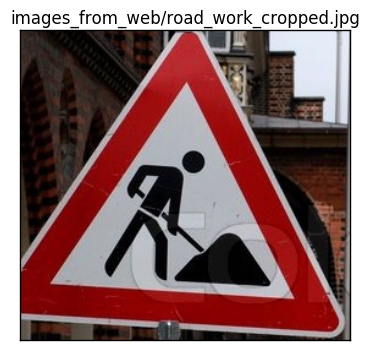

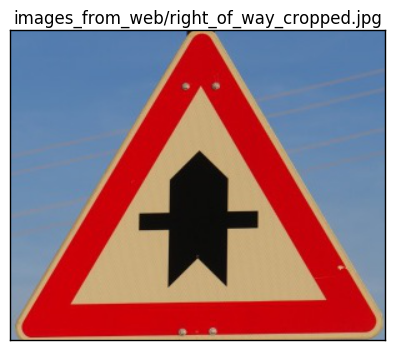

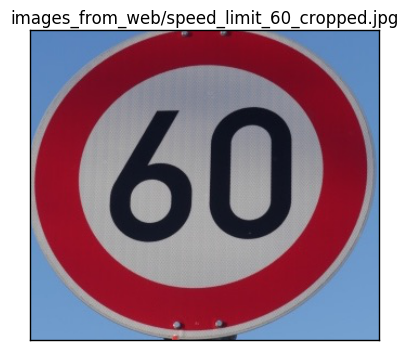

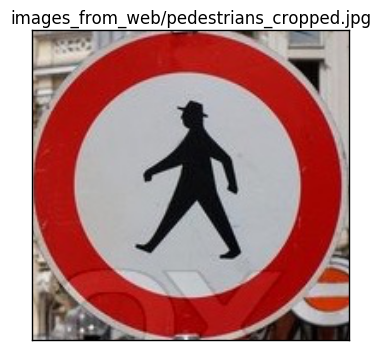

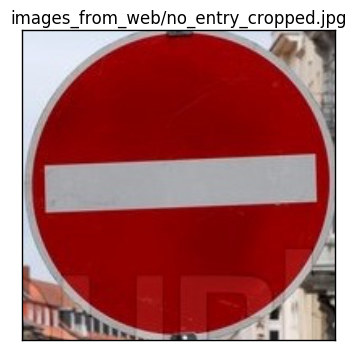

In [11]:
images_path = 'images_from_web/*.jpg'
image_files = glob.glob(images_path)

for fname in image_files:
    img = cv2.imread(fname)
    show_images([img], titles=[fname])

In [ ]:
### Feel free to use as many code cells as needed.

newImagePaths = ['images_from_web/no_entry_cropped.jpg',
                 'images_from_web/speed_limit_60_cropped.jpg',
                 'images_from_web/right_of_way_cropped.jpg',
                 'images_from_web/pedestrians_cropped.jpg',
                 'images_from_web/road_work_cropped.jpg']
thumbnails = []

def populateImageArrayCollection(image):
    image= image.resize((32,32),Image.ANTIALIAS)
    thumbnailArray = np.reshape(image,(32,32,3))
    thumbnails.append(thumbnailArray)
    return thumbnails

def populateNewImages():
    for imagePath in newImagePaths:
        thumbnails = populateImageArrayCollection(
            Image.open(imagePath))
    thumbnails = np.asarray(thumbnails,dtype=np.float32); 
    return thumbnails 

newImages = populateNewImages()
# newImages above is 32x32x3 - so transform as needed, just like the
# training set preprocessing
newImages = np.mean(newImages, axis=3)
newImages = normalize_greyscale(newImages)

def populateOHELabelsForNewImages():
    no_entry_cropped_label = np.zeros((1,43))
    no_entry_cropped_label[0,17] = 1
    speed_limit_60_cropped_label = np.zeros((1,43))
    speed_limit_60_cropped_label[0,3] = 1
    right_of_way_cropped_label = np.zeros((1,43))
    right_of_way_cropped_label[0,11] = 1
    pedestrians_cropped_label = np.zeros((1,43))
    pedestrians_cropped_label[0,27] = 1
    road_work_cropped_label = np.zeros((1,43))
    road_work_cropped_label[0,25] = 1
    return np.vstack([no_entry_cropped_label,
                      speed_limit_60_cropped_label,
                      right_of_way_cropped_label,
                      pedestrians_cropped_label,
                      road_work_cropped_label])

newImagesOHELabels = populateOHELabelsForNewImages()

In [ ]:
### Run the predictions for the new images here.
### Feel free to use as many code cells as needed.
init_op = tf.global_variables_initializer()
prediction = tf.nn.softmax(fc2)
topPredictions=tf.nn.top_k(prediction, k=5, sorted=True, name=None)

top_k_feed_dict = {x: newImages, y: newImagesOHELabels}

with tf.Session() as session:
    # Run the init operation.
    session.run(init_op)
    top_k_pred = session.run(topPredictions, feed_dict = top_k_feed_dict)
    top5_pred_sftmax = top_k_pred[0]
    top5_pred_labels = top_k_pred[1]

print(newImagePaths)
np.set_printoptions(precision=3)
print(top5_pred_sftmax)
print(top5_pred_labels)


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**
Based on the above there appears to be a rather poor classification of images obtained from the web.
The above indicates that the following was inferred (using signnames.csv)-
- 'no_entry_cropped.jpg'-> 39:Keep left
- 'speed_limit_60_cropped.jpg'-> 14:Stop
- 'right_of_way_cropped.jpg'-> 23:Slippery Road
- 'pedestrians_cropped.jpg'-> 14:Stop 
- 'road_work_cropped.jpg'-> 23:Slippery Road

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
init_op = tf.global_variables_initializer()
prediction = tf.nn.softmax(fc2)
topPredictions=tf.nn.top_k(prediction, k=5, sorted=True, name=None)

top_k_feed_dict = {x: X_train, y: y_train}

with tf.Session() as session:
    # Run the init operation.
    session.run(init_op)
    top_k_pred = session.run(topPredictions, feed_dict = top_k_feed_dict)
    top5_pred_sftmax = top_k_pred[0]
    top5_pred_labels = top_k_pred[1]

# print(newImagePaths)
np.set_printoptions(precision=3)
print(top5_pred_sftmax)
print(top5_pred_labels)

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**
Based on the above there appears to be a rather poor **certainty** of predictions, as the probablities are almost uniformly distributed.


### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**
A web or native GUI interface has not been provided.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.